## WKT to Segmentation Mask

This notebook illustrates an example to convert segmentation WKTs into grayscale image mask.

This example uses:  
- `PIL` library for image I/O and drawing mask
- `shapely` for pre-processing WKTs and generating polygons

If you recieved your WKTs from Centaur, they will be formatted with relative coordinates.
Make sure to convert them to absolute coordinates first. Check the (@TODO: Link recipe)
recipe to do the conversion.

This script does not handle shapes with holes.

In [1]:
# imports
import json
import numpy as np

from PIL import Image, ImageDraw

import shapely.wkt
import shapely.geometry
from shapely.affinity import scale

In [2]:
# inputs paths
JSON_WKT_PATH = "./example/input/example_mask_wkt.json"
BASE_IMAGE_FILE_PATH = "./example/input/example_base.png"
# output path
MASK_IMAGE_FILE_PATH = "./example/output/example_mask.png"

### segmentation wkts to grayscale mask

In [3]:
# load wkts from json
with open(JSON_WKT_PATH) as f:
    list_of_wkt_masks = json.load(f)
list_of_wkt_masks

[{'intensity': 64,
  'wkt': 'POLYGON ((572 507, 566 512, 566 518, 557 534, 555 561, 548 579, 542 622, 515 716, 505 772, 494 806, 484 822, 483 855, 488 874, 498 883, 546 887, 571 898, 586 898, 608 889, 624 874, 627 867, 627 845, 621 833, 621 825, 608 786, 608 754, 615 703, 618 645, 642 586, 665 563, 666 546, 664 537, 654 526, 585 507, 572 507))'},
 {'intensity': 156,
  'wkt': 'POLYGON ((677 301, 667 308, 642 359, 630 391, 608 420, 578 480, 578 494, 582 505, 636 520, 656 520, 669 516, 681 498, 685 476, 685 447, 691 431, 691 413, 701 385, 733 345, 738 335, 738 325, 731 312, 712 304, 692 305, 677 301))'},
 {'intensity': 255,
  'wkt': 'POLYGON ((729 137, 718 143, 712 152, 685 249, 683 265, 676 269, 672 278, 672 290, 676 296, 705 298, 720 307, 733 305, 749 284, 750 265, 744 251, 742 227, 748 218, 748 209, 755 204, 763 185, 761 170, 754 156, 742 142, 729 137))'}]

In [4]:
# load base image
base_image = Image.open(BASE_IMAGE_FILE_PATH).convert("L")
height = int(base_image.height)
width = int(base_image.width)

# prepare blank canvas
canvas = np.zeros((height, width))

# get the scaling factors
y_factor = height/100
x_factor = width/100

print (f"Scaling factor for height :: {height} and width :: {width} is ({y_factor}, {x_factor})")
       
# draw mask
mask_image = Image.fromarray(np.uint8(canvas))
for wkt_mask in list_of_wkt_masks:
    mask_polygon = shapely.wkt.loads(wkt_mask["wkt"])
    scaled_polygon = scale(mask_polygon, xfact=x_factor, yfact=y_factor, origin=(0, 0))
    mask_poly_coords = list(scaled_polygon.exterior.coords)
    if mask_polygon.is_empty:
        continue
    mask_poly_coords = list(mask_polygon.exterior.coords)
    ImageDraw.Draw(mask_image).polygon(mask_poly_coords, fill=wkt_mask["intensity"])

# save mask
mask_image.save(MASK_IMAGE_FILE_PATH)

Scaling factor for height :: 2098 and width :: 1003 is (20.98, 10.03)


### visualize generated mask on base image

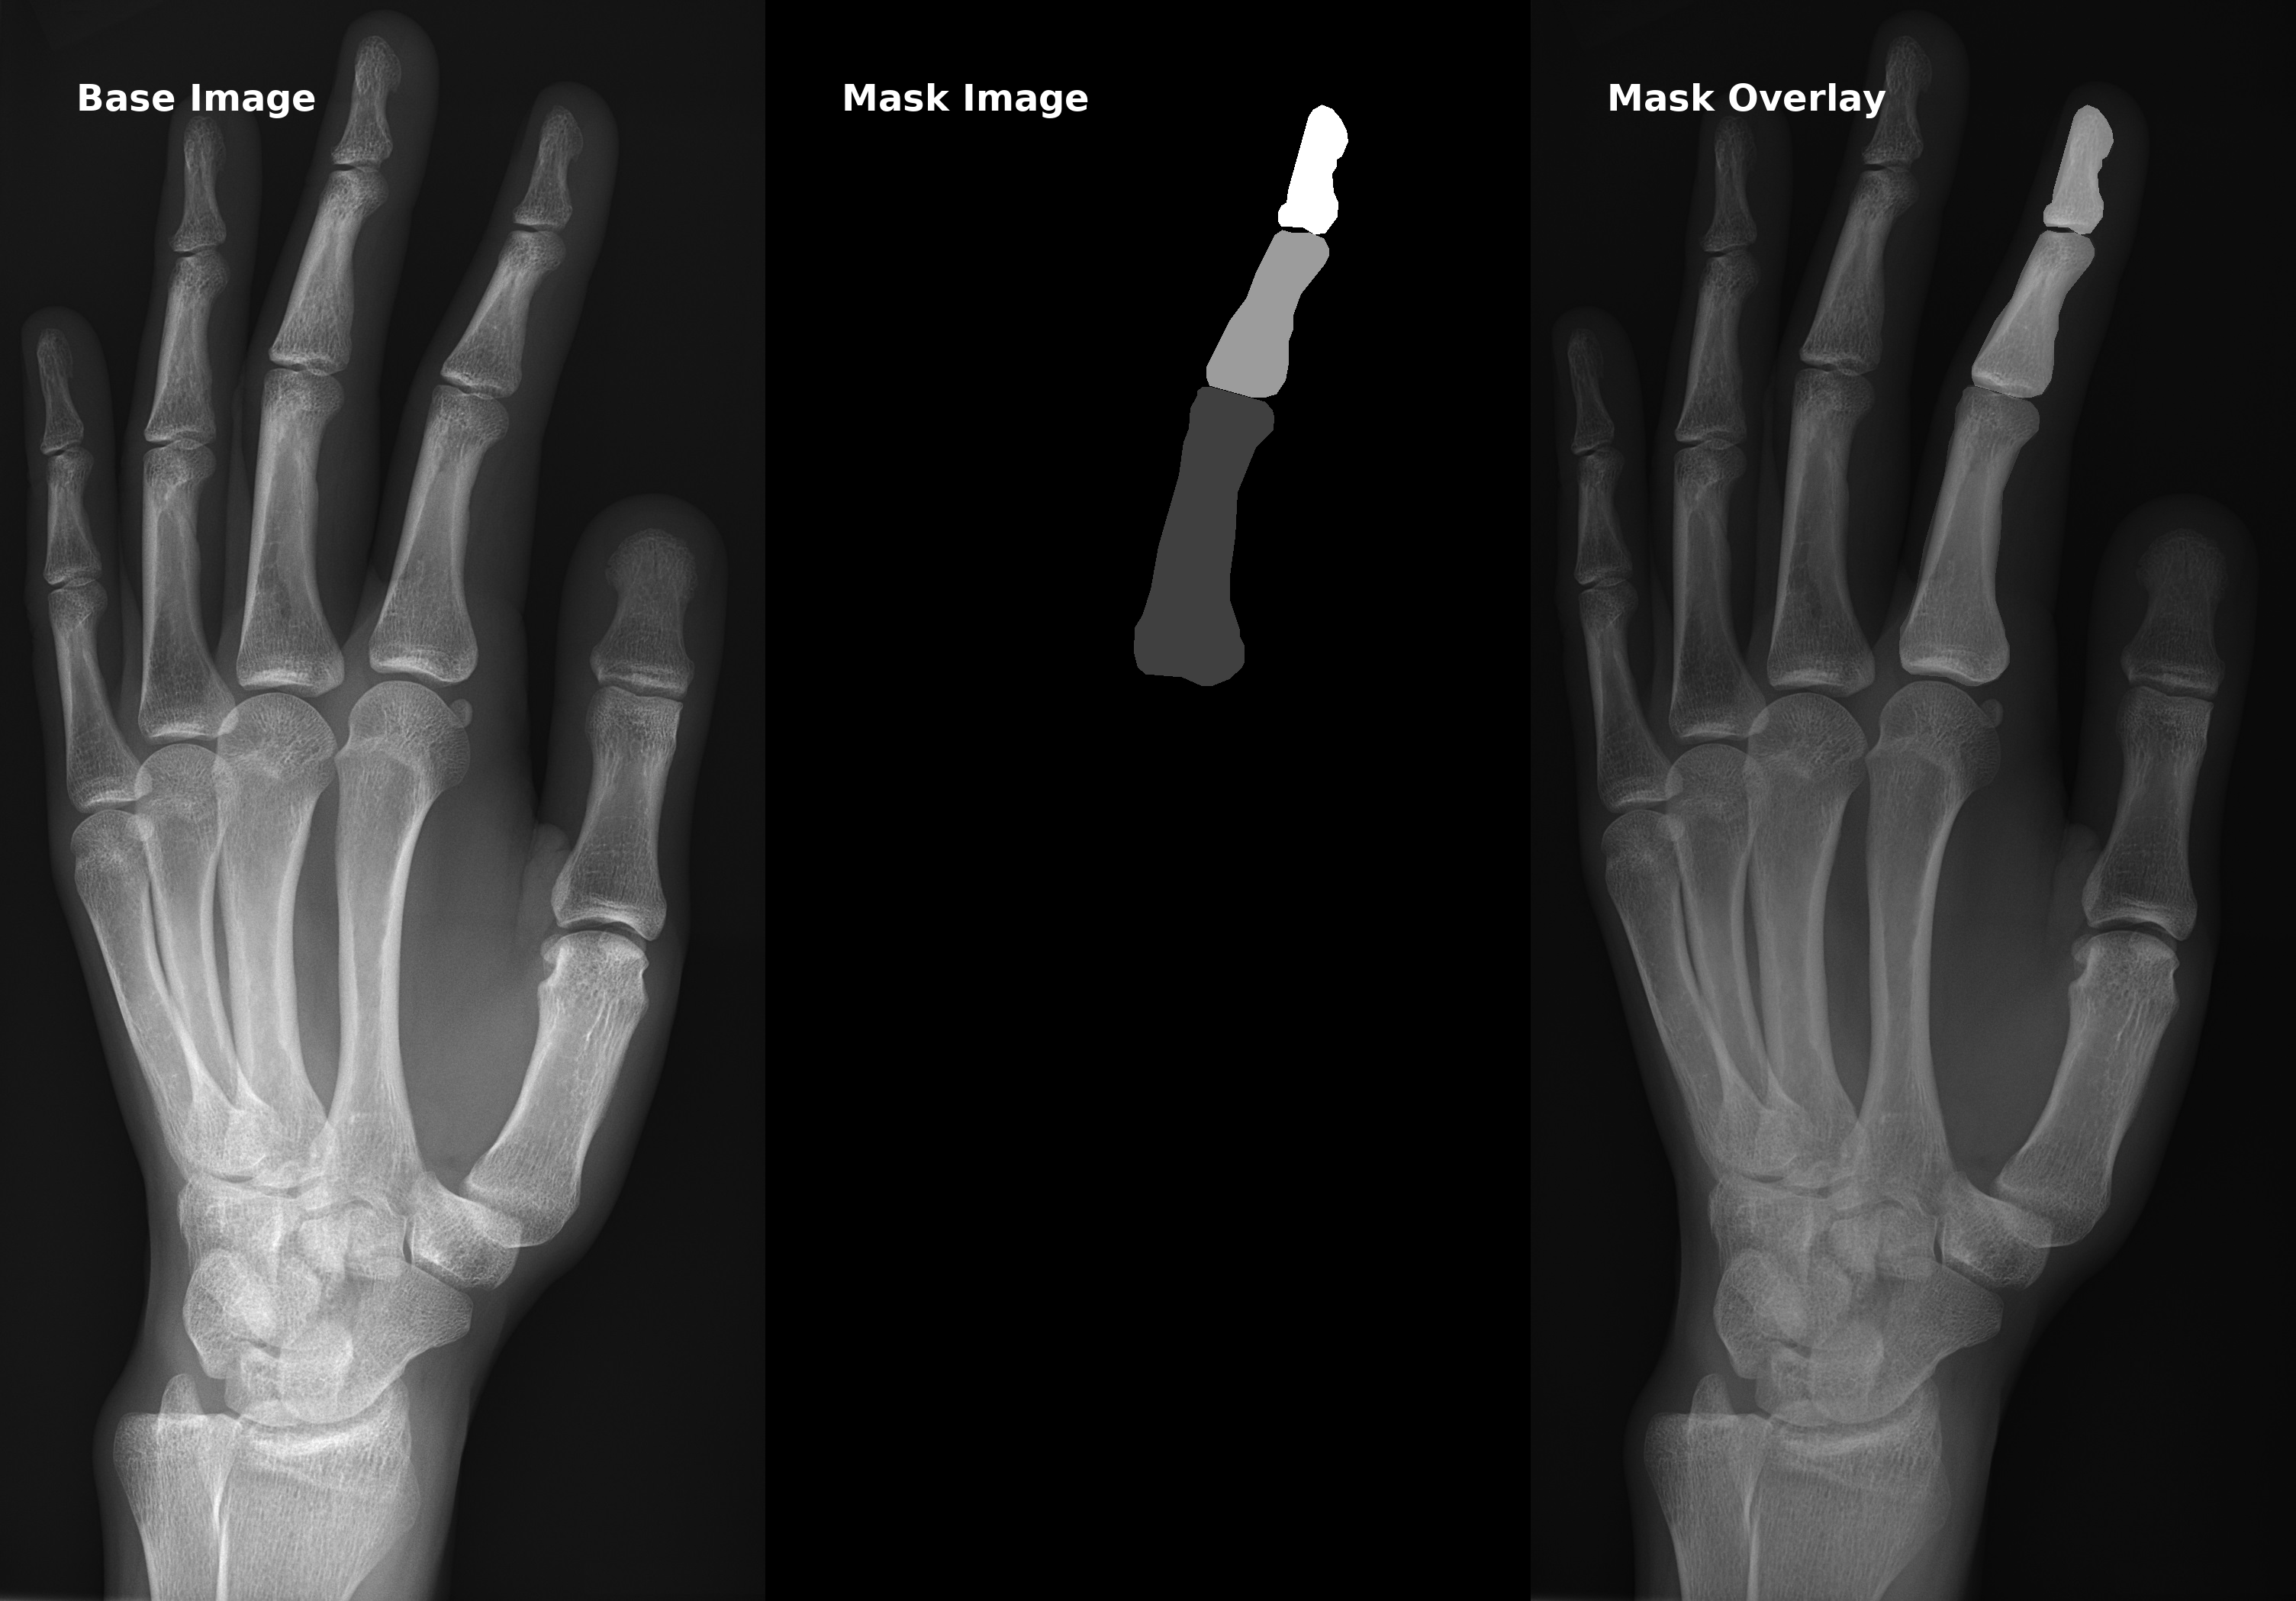

In [5]:
from PIL import ImageFont
from matplotlib import font_manager

font = font_manager.FontProperties(family="sans-serif", weight="bold")
font = ImageFont.truetype(font_manager.findfont(font), 48)

# overlay mask
composite_image = Image.blend(mask_image, base_image, alpha=0.6)

# show overlay
ImageDraw.Draw(base_image := base_image.convert("RGBA")).text(
    (100, 100), "Base Image", (255, 255, 255), font=font
)
ImageDraw.Draw(mask_image := mask_image.convert("RGBA")).text(
    (100, 100), "Mask Image", (255, 255, 255), font=font
)
ImageDraw.Draw(composite_image := composite_image.convert("RGBA")).text(
    (100, 100), "Mask Overlay", (255, 255, 255), font=font
)
overlay_strip = Image.fromarray(
    np.hstack((np.array(base_image), np.array(mask_image), np.array(composite_image)))
)
overlay_strip